In [11]:
import time
import numpy as np
import yaml
import sys
import awkward as ak
import uproot as ur
sys.path.append('/home/jbohm/start_tf/LCStudies')
from data import particle_data_visualize_plot_utils as pu
import matplotlib.pyplot as plt
import math
import matplotlib as mpl
from numpy import genfromtxt
import vector



In [2]:
# helper functions
def spherical_to_cartesian(rs, phis, thetas):
    # convert to x, y, z
    x, y, z = [], [], []

    for i, r in enumerate(rs):
        x.append(r*np.cos(phis[i]))
        y.append(r*np.sin(phis[i]))
        z.append( r/np.tan(thetas[i]))

    return np.array(x), np.array(y), np.array(z)

def flatten_clus_in_events(events):
    return [[cell for clus in event for cell in clus] for event in events]

def flatten_one_layer(data):
    return [data_layer2 for data_layer1 in data for data_layer2 in data_layer1]

def flatten_layers(data, num_layers=1):
    for i in range(num_layers):
        data = flatten_one_layer(data)
    return data


In [3]:
pastel_colors = [
    #"#440154FF",
    #"#FDE725FF",
    #"#74BF43",
    (0.6784, 0.8471, 0.9020),  # Lightblue
    (1.0000, 0.7137, 0.7569),  # Lightpink
    (0.8196, 0.7686, 0.9412),  # Lavender
    
    (0.5647, 0.9333, 0.5647),  # Lightgreen
    (1.0000, 0.9804, 0.8039),  # Lightyellow
    
    (1.0000, 0.6275, 0.4784),  # Lightsalmon
    (0.8471, 0.7490, 0.8471),  # Thistle
    (1.0000, 0.8941, 0.8824),  # Mistyrose
    (1.0000, 0.8549, 0.7255)   # Peachpuff
]


def plot_proccessed_cells_in_line(x, y, z, cell_data, title, xlabel, ylabel, zlabel, colour_theme, bar_label, event_idx=None, vmin=None, vmax=None, same_axis=True, add_track=False, add_topo=False):
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    fig.set_size_inches(5*len(cell_data), 5)
    for i, cell_data_i in enumerate(cell_data):
        ax = fig.add_subplot(1, len(cell_data), i + 1, projection='3d')
        x_i = x[i] if len(x) > 1 else x[0]
        y_i = y[i] if len(y) > 1 else y[0]
        z_i = z[i] if len(z) > 1 else z[0]
        xlabel_i = xlabel[i] if len(xlabel) > 1 else xlabel[0]
        ylabel_i = ylabel[i] if len(ylabel) > 1 else ylabel[0]
        zlabel_i = zlabel[i] if len(zlabel) > 1 else zlabel[0]
        title_i = title[i] if len(title) > 1 else title[0]

        if title[i] == "Clustered cells":
            for clus_idx in range(2):#range(0, np.max(processed_event_data["clus_idx"][event_idx]) + 1):
                ax.scatter(processed_event_data["z"][event_idx][processed_event_data["clus_idx"][event_idx] == clus_idx], processed_event_data["x"][event_idx][processed_event_data["clus_idx"][event_idx] == clus_idx], processed_event_data["y"][event_idx][processed_event_data["clus_idx"][event_idx] == clus_idx], label=["pi class", "pi/pi class"][clus_idx], color=pastel_colors[clus_idx])
            ax.legend()
            
        elif bar_label[i] == "Pi+/- frac class" or bar_label[i] == "Pred EM frac class":
            cut_em_class = np.array(cell_data_i) == 1
            clus_x = np.array(x_i)
            clus_y = np.array(y_i)
            clus_z = np.array(z_i)
            ax.scatter(clus_z[cut_em_class], clus_x[cut_em_class], clus_y[cut_em_class], color="fuchsia")
            ax.scatter(clus_z[~cut_em_class], clus_x[~cut_em_class], clus_y[~cut_em_class], color="cyan")  
        #elif title[i] == "Cluster EM probability":
        #    print("not loaded atm")
        elif title[i] == "Input point data":
            p = ax.scatter(z_i, x_i, y_i, c=cell_data_i, vmin=vmin[i], vmax=vmax[i], cmap=colour_theme[i], zorder=1, norm=mpl.colors.LogNorm())
            #if bar_label[i] != "EM frac class":
            #fig.colorbar(p, label=bar_label[i], fraction=0.025, pad=0.15)
        else:
            p = ax.scatter(z_i, x_i, y_i, c=cell_data_i, vmin=vmin[i], vmax=vmax[i], cmap=colour_theme[i], zorder=1)
            #if bar_label[i] != "EM frac class":
            #fig.colorbar(p, label=bar_label[i], fraction=0.025, pad=0.15)
        
        if add_track and (title[i] == "Input point data" or title[i] == "Input point data" or title[i] == "Fraction of cell energy from pi" or title[i] == "Cell truth classes"):
            ax.scatter(processed_event_track_data["z"][event_idx][processed_event_track_data["z"][event_idx] != 0], processed_event_track_data["x"][event_idx][processed_event_track_data["x"][event_idx] != 0], processed_event_track_data["y"][event_idx][processed_event_track_data["y"][event_idx] != 0], color="black")
            ax.plot(processed_event_track_data["z"][event_idx][processed_event_track_data["z"][event_idx] != 0], processed_event_track_data["x"][event_idx][processed_event_track_data["x"][event_idx] != 0], processed_event_track_data["y"][event_idx][processed_event_track_data["y"][event_idx] != 0], color="black")
            ax.set_xlim(np.min(z_i), np.max(z_i))
            ax.set_ylim(np.min(x_i), np.max(x_i))
            ax.set_zlim(np.min(y_i), np.max(y_i))

        if add_topo and title[i] == "Predicted classes (+ clusters)":
            for clus_idx in range(0, np.max(processed_event_data["clus_idx"][event_idx]) + 1):
                ax.scatter(processed_event_data["z"][event_idx][processed_event_data["clus_idx"][event_idx] == clus_idx], processed_event_data["x"][event_idx][processed_event_data["clus_idx"][event_idx] == clus_idx], processed_event_data["y"][event_idx][processed_event_data["clus_idx"][event_idx] == clus_idx], marker=",", s=90, alpha=0.2, zorder=-1, label="cluster " + str(clus_idx + 1), color=pastel_colors[clus_idx])
            ax.legend()
        ax.set_xlabel(xlabel_i)
        ax.set_ylabel(ylabel_i)
        ax.set_zlabel(zlabel_i)
        plt.title(title_i)
    plt.show()


# plot 3d event info
def plot_event_3d_info(event_idx, pipm_frac, class_pipm_frac, preds):
    x = processed_event_data["x"][event_idx]
    y = processed_event_data["y"][event_idx] 
    z = processed_event_data["z"][event_idx]
    
    title = ["Sampling layers", "Input point data", "Fraction of cell energy from pi", "Clustered cells", "Cell truth classes", "Cluster EM probability", "Predicted classes", "Predicted classes (+ clusters)"]
    xlabel = ["z"]
    ylabel = ["x"]
    zlabel = ["y"]

    colour_theme = [plt.cm.tab20b, plt.cm.magma, plt.cm.viridis_r, None, plt.cm.viridis_r, plt.cm.viridis_r, plt.cm.viridis_r, plt.cm.viridis_r]
    bar_label = ["Sampling layers", "Cell energy (GeV)", "pi energy frac", "", "Truth Pi0 frac class",  "EM probability", "Predicted classes", "Predicted classes"]
    vmin = [0, None , 0, None, 0, 0, 0, 0]
    vmax = [23, None, 1, None, 1, 1, 1, 1]
    cell_data = [processed_event_data["sampling_layer"][event_idx],  10**(np.array(processed_event_data["cell_E"][event_idx]) + LOG_ENERGY_MEAN), pipm_frac, None, class_pipm_frac, processed_event_data["clus_em_prob"][event_idx], preds, preds]
    #cell_data = [processed_event_data["sampling_layer"][event_idx],  processed_event_data["cell_E"][event_idx], pipm_frac, None, class_pipm_frac, None, preds, preds]
    
    #plot_proccessed_cells_in_line([x], [y], [z], cell_data[:4], title[:4], xlabel, ylabel, zlabel, colour_theme[:4], bar_label[:4], event_idx, vmin[:4], vmax[:4], add_track=True, add_topo=True)
    #plot_proccessed_cells_in_line([x], [y], [z], cell_data[4:], title[4:], xlabel, ylabel, zlabel, colour_theme[4:], bar_label[4:], event_idx, vmin[4:], vmax[4:], add_track=True, add_topo=True)
    for i in range(len(title)):
        plot_proccessed_cells_in_line([x], [y], [z], [cell_data[i]], [title[i]], xlabel, ylabel, zlabel, [colour_theme[i]], [bar_label[i]], event_idx, [vmin[i]], [vmax[i]], add_track=True, add_topo=True)
        

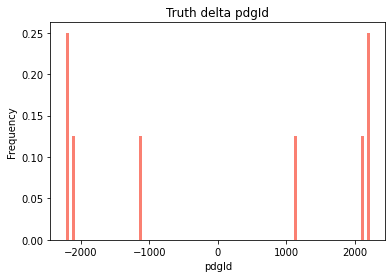

In [4]:
events = ur.open("/fast_scratch_1/atlas_images/MLTree/delta_full_small.root:EventTree")

delta_pdgIds = ak.Array(events["truthPartPdgId"].array())[:, 0]
pu.plot_hist(np.array(delta_pdgIds), 100, "Truth delta pdgId", "pdgId", "Frequency", colour="salmon")

# conversion to arrays takes 

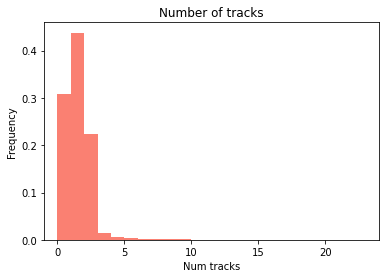

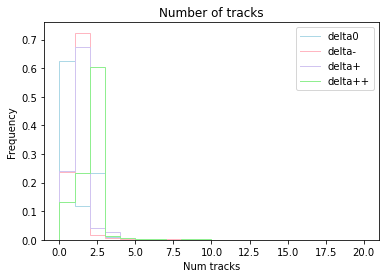

In [5]:
pdgId_dict = {
    2114: "delta0",
    1114: "delta-",
    2214: "delta+",
    2224: "delta++",
}

num_tracks_arr = np.array(events["nTrack"])
pdgIds_arr = np.array(ak.Array(np.array(events["truthPartPdgId"]))[:, 0])
pu.plot_hist(np.array(events["nTrack"]), 20, "Number of tracks", "Num tracks", "Frequency", colour="salmon", xlim=(-1,24))

num_tracks = []
labels = []

for delta_pdgId in pdgId_dict:
    pdgId_cut = (np.abs(pdgIds_arr) == delta_pdgId)
    num_tracks.append(num_tracks_arr[pdgId_cut])
    labels.append(pdgId_dict[delta_pdgId])

    # filter based on pdgId
    """
    pdgId_cut = (pdgIds_arr == delta_pdgId)
    neg_pdgId_cut = (pdgIds_arr == -delta_pdgId)
    num_tracks.append(num_tracks_arr[pdgId_cut])
    num_tracks.append(num_tracks_arr[neg_pdgId_cut])
    labels.append(delta_pdgId)
    labels.append(-1*delta_pdgId)
    """


pu.plot_overlay_hist(num_tracks, 20, "Number of tracks", "Num tracks", "Frequency", labels=labels, colours=pastel_colors)


In [6]:
# for one type of delta event look into the dist between the tracks and charged particles
np.set_printoptions(threshold=sys.maxsize)
abs_pdgId = 2224
delta_pdgIds = ak.Array(np.array(events["truthPartPdgId"]))[:,0]
cut_delta_events_idx = np.arange(len(np.array(events["nTrack"])))[np.abs(delta_pdgIds) == abs_pdgId]


unique_pdgIds_tuples = set([tuple(event_pdgIds) for event_pdgIds in np.array(events["truthPartPdgId"])[cut_delta_events_idx]])
unique_pdgIds_lists = [list(pdgIds_tuple) for pdgIds_tuple in unique_pdgIds_tuples]
print("num unique lists:", len(unique_pdgIds_lists))

for pdgIds_list in unique_pdgIds_lists:
    print(pdgIds_list)

#print(set(np.array(events["truthPartPdgId"])[cut_delta_events_idx]))
#for event_idx in cut_delta_events_idx:
#    for 



num unique lists: 8
[-2224, -2212, -211, 22, 22, 22]
[-2224, -2212, -211, 22, 22]
[2224, 2212, 211, 22, 22, 22]
[2224, 2212, 211, 22]
[2224, 2212, 211]
[2224, 2212, 211, 22, 22]
[-2224, -2212, -211]
[-2224, -2212, -211, 22]


delta_plus_pi0
frac with this decay: 0.16494
num unique lists: 5
[2214, 2212, 111, 11, 11, 22] num events: 112 - frac of events: 0.014
[2214, 2212, 111, 22, 22, 22, 22] num events: 4 - frac of events: 0.0
[2214, 2212, 111, 22, 22, 22] num events: 234 - frac of events: 0.028
[2214, 2212, 111, 11, 11, 22, 22] num events: 2 - frac of events: 0.0
[2214, 2212, 111, 22, 22] num events: 7895 - frac of events: 0.957



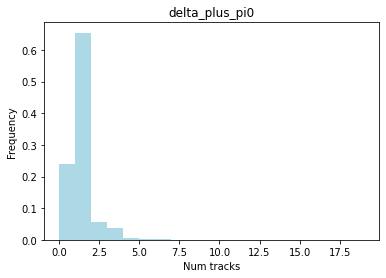

delta_plus_pipm
frac with this decay: 0.08362
num unique lists: 5
[2214, 2112, 211, 22] num events: 497 - frac of events: 0.119
[2214, 2112, 211] num events: 3646 - frac of events: 0.872
[2214, 2112, 211, 22, 22, 22] num events: 3 - frac of events: 0.001
[2214, 2112, 211, 22, 22] num events: 34 - frac of events: 0.008
[2214, 2112, 211, 22, 22, 22, 22] num events: 1 - frac of events: 0.0



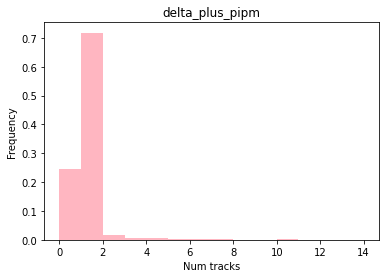

delta_0_pi0_n
frac with this decay: 0.16606
num unique lists: 3
[2114, 2112, 111, 22, 22] num events: 8122 - frac of events: 0.978
[2114, 2112, 111, 11, 11, 22] num events: 99 - frac of events: 0.012
[2114, 2112, 22] num events: 82 - frac of events: 0.01



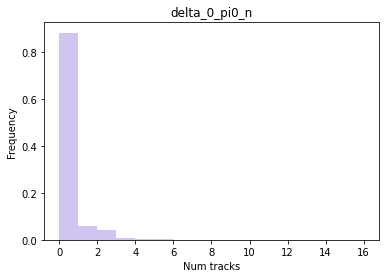

delta_0_pipm_p
frac with this decay: 0.08394
num unique lists: 5
[2114, 2212, 211] num events: 3436 - frac of events: 0.819
[2114, 2212, 211, 22, 22, 22, 22] num events: 2 - frac of events: 0.0
[2114, 2212, 211, 22] num events: 688 - frac of events: 0.164
[2114, 2212, 211, 22, 22] num events: 67 - frac of events: 0.016
[2114, 2212, 211, 22, 22, 22] num events: 4 - frac of events: 0.001



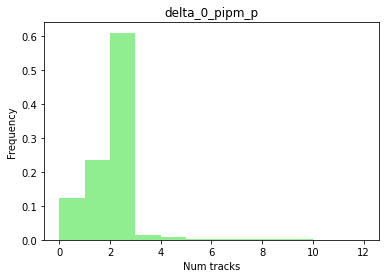

delta_plus_plus
frac with this decay: 0.25
num unique lists: 4
[2224, 2212, 211] num events: 11248 - frac of events: 0.9
[2224, 2212, 211, 22, 22, 22] num events: 3 - frac of events: 0.0
[2224, 2212, 211, 22] num events: 1170 - frac of events: 0.094
[2224, 2212, 211, 22, 22] num events: 79 - frac of events: 0.006



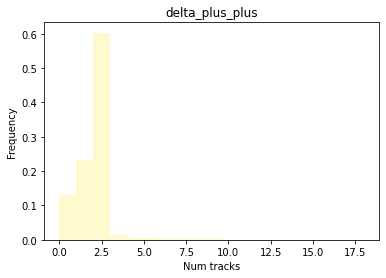

delta_min
frac with this decay: 0.25
num unique lists: 4
[1114, 2112, 211, 22, 22] num events: 98 - frac of events: 0.008
[1114, 2112, 211] num events: 11040 - frac of events: 0.883
[1114, 2112, 211, 22, 22, 22] num events: 3 - frac of events: 0.0
[1114, 2112, 211, 22] num events: 1359 - frac of events: 0.109



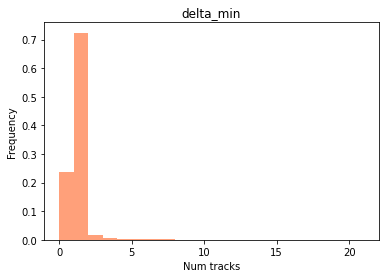

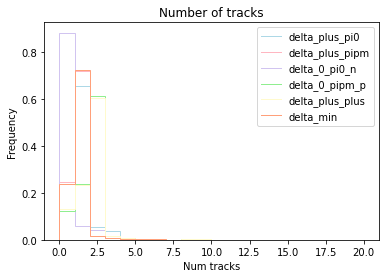

In [16]:
# most of the analysis will be by decay group => get cuts by decay group
truthPartPdgIds = ak.Array(np.abs(events["truthPartPdgId"].array()))
decay_group_cuts = {
    "delta_plus_pi0": (truthPartPdgIds[:, 0] == 2214) & (truthPartPdgIds[:, 2] == 111),
    "delta_plus_pipm": (truthPartPdgIds[:, 0] == 2214) & (truthPartPdgIds[:, 2] == 211),
    "delta_0_pi0_n": (truthPartPdgIds[:, 0] == 2114) & (truthPartPdgIds[:, 1] == 2112),
    "delta_0_pipm_p": (truthPartPdgIds[:, 0] == 2114) & (truthPartPdgIds[:, 1] == 2212),
    "delta_plus_plus": (truthPartPdgIds[:, 0] == 2224),
    "delta_min": (truthPartPdgIds[:, 0] == 1114),
}

# get the number of tracks for each decay group
num_tracks = []

for i, decay_cut in enumerate(decay_group_cuts.keys()):
    print(decay_cut)
    print("frac with this decay:", len(truthPartPdgIds[decay_group_cuts[decay_cut]])/len(truthPartPdgIds))

    # get the unique decay sets for the cut
    unique_pdgIds_tuples = set([tuple(event_pdgIds) for event_pdgIds in truthPartPdgIds[decay_group_cuts[decay_cut]]])
    unique_pdgIds_lists = [list(pdgIds_tuple) for pdgIds_tuple in unique_pdgIds_tuples]
    print("num unique lists:", len(unique_pdgIds_lists))

    for pdgIds_list in unique_pdgIds_lists:
        num_events = np.count_nonzero([(len(cut_pdgIds) == len(pdgIds_list)) and np.all((cut_pdgIds == pdgIds_list)) for cut_pdgIds in truthPartPdgIds[decay_group_cuts[decay_cut]]])
        print(pdgIds_list, "num events:", num_events, "- frac of events:", round(num_events/len(truthPartPdgIds[decay_group_cuts[decay_cut]]), 3))
    print()

    # get the number of tracks for each decay group
    num_tracks_cut = events["nTrack"].array()[decay_group_cuts[decay_cut]]
    num_tracks.append(num_tracks_cut)

    pu.plot_hist(np.array(num_tracks_cut), np.max(num_tracks_cut) + 1, decay_cut, "Num tracks", "Frequency", colour=pastel_colors[i], discrete=True)

pu.plot_overlay_hist(ak.Array(num_tracks), 20, "Number of tracks", "Num tracks", "Frequency", labels=list(decay_group_cuts.keys()), colours=pastel_colors)



In [12]:
# look into charged particle dist from track for each decay case of delta

def measure_track_part_dists(track_phi, track_eta, track_p, part_phi, part_eta, part_p):
    part_vectors = vector.obj(eta=part_eta, phi=part_phi, rho=part_p)
    track_vectors = vector.obj(eta=track_eta, phi=track_phi, rho=track_p)

    return part_vectors.deltaR(track_vectors)

# one track cases - a) delta_plus_pi0 (delta+ -> pi0 & proton -> pi0 & gammas -> gammas), b) delta+ (delta+ -> pi+/- & neutron), c) delta- (delta- -> pi+/- & neutron -> pi0 -> gammas)
# measure dist between charged particle a) delta_plus_pi0 proton at idx = 1, b) delta_plus_pipm pi+/- at idx = 2, c) delta_min pi+/- at idx = 2 and track
nTrack = events["nTrack"].array()

part_phis = events["truthPartPhi"].array()
part_etas = events["truthPartEta"].array()
part_p = events["truthPartPt"].array()

track_phis = events["trackPhi"].array()
track_etas = events["trackEta"].array()
track_p = events["trackPt"].array()


event_cut = decay_group_cuts["delta_plus_pi0"] & (nTrack[decay_group_cuts["delta_plus_pi0"]] == 1)
track_phi = track_phis[event_cut]
track_eta = track_etas[event_cut]
track_p = track_p[event_cut]

track_dists = measure_track_part_dists(track_phi, track_eta, track_p, part_phi, part_eta, part_p)
